In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import numpy as np
import json
import seaborn as sns

In [2]:
fs = 12
plt.rcParams.update({
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

In [4]:
wien2k_data = pd.read_csv('/Users/treents/project/aiida-cwf/data/meta-GGA/WIEN2k/summary_pbe_scan_r2scan_r2scan01-2missing.txt', sep='\s+', header=1)
wien2k_data.columns = ['element', 'pbe', 'scan', 'r2scan', 'r2scan01']
wien2k_data = wien2k_data.set_index('element')

with open('/Users/treents/project/aiida-cwf/data/meta-GGA/FHI-aims/R2SCAN.json', 'r') as f:
    fhi_aims_r2scan = json.load(f)

with open('/Users/treents/project/aiida-cwf/data/meta-GGA/FHI-aims/R2SCAN01.json', 'r') as f:
    fhi_aims_r2scan01 = json.load(f)
    
with open('/Users/treents/project/aiida-cwf/data/meta-GGA/FHI-aims/rt_rscan01-fhi-aims.json', 'r') as f:
    fhi_aims_r2scan01_v2 = json.load(f)
    
fhi_aims_volumes = {
    'r2scan': {k: v['min_volume'] for k, v in fhi_aims_r2scan['BM_fit_data'].items()},
    'r2scan01': {k: v['min_volume'] for k, v in fhi_aims_r2scan01['BM_fit_data'].items()},
    'r2scan01_v2': {k: v['min_volume'] for k, v in fhi_aims_r2scan01_v2['BM_fit_data'].items()}
}

In [13]:
def volume_to_lattice_constant(volume, structure_type):
    if structure_type == 'BCC':
        return (2 * volume) ** (1/3)
    elif structure_type == 'FCC':
        return (4 * volume) ** (1/3)
    elif structure_type == 'Diamond':
        return (4 * volume) ** (1/3)
    else:
        raise ValueError("Unknown structure type")

# Example usage:

structure_types = {
    'Ba-X/BCC': 'BCC', 'Cs-X/BCC': 'BCC', 'K-X/BCC': 'BCC', 'Li-X/BCC': 'BCC', 'Mo-X/BCC': 'BCC', 
    'Na-X/BCC': 'BCC', 'Nb-X/BCC': 'BCC', 'Rb-X/BCC': 'BCC', 'Ta-X/BCC': 'BCC', 'V-X/BCC': 'BCC', 
    'W-X/BCC': 'BCC', 'Ag-X/FCC': 'FCC', 'Al-X/FCC': 'FCC', 'Au-X/FCC': 'FCC', 'Ca-X/FCC': 'FCC', 
    'Cu-X/FCC': 'FCC', 'Ir-X/FCC': 'FCC', 'Ni-X/FCC': 'FCC', 'Pd-X/FCC': 'FCC', 'Pt-X/FCC': 'FCC', 
    'Rh-X/FCC': 'FCC', 'Sr-X/FCC': 'FCC', 'C-X/Diamond': 'Diamond', 'Ge-X/Diamond': 'Diamond', 
    'Si-X/Diamond': 'Diamond', 'Sn-X/Diamond': 'Diamond'
}

lattice_constants = {}
for funct, fhi_aims_vol in fhi_aims_volumes.items():
    
    lattice_constants[funct] = {
        element: volume_to_lattice_constant(volume, structure_types[element]) 
        for element, volume in fhi_aims_vol.items()
        }

fhi_aims_df = pd.DataFrame(lattice_constants)

fhi_aims_df['element'] = fhi_aims_df.index.to_series().apply(lambda x: x.split('-X')[0])
fhi_aims_df = fhi_aims_df.set_index('element')

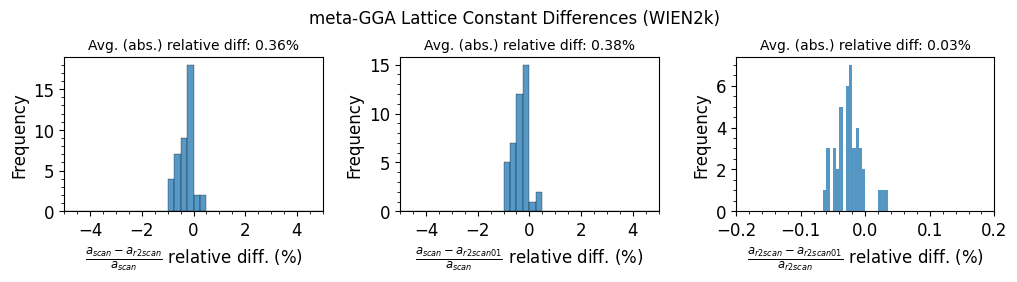

In [14]:
diff_labels = list(combinations(wien2k_data.drop('pbe', axis=1).columns, 2))

# Create subplots for relative differences
fig, axes = plt.subplots(nrows=len(diff_labels)//3, ncols=3, figsize=(12, 2.5*len(diff_labels)//3))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

# Plot each column in a separate subplot
for ax, labs in zip(axes.flatten(), diff_labels):
    relative_diff = (wien2k_data[labs[0]] - wien2k_data[labs[1]]) / wien2k_data[labs[0]] * 100
    bins = np.arange(-10, 10, 0.25)
    if 'r2scan' in labs and 'r2scan01' in labs:
        bins = np.arange(-5, 5, 0.005)
    sns.histplot(relative_diff, bins=bins, ax=ax)
    # ax.set_title(f'Relative Difference of {col}')
    ax.set_xlabel(f'$\\frac{{a_{{{labs[0]}}} - a_{{{labs[1]}}}}}{{a_{{{labs[0]}}}}}$ relative diff. (%)')
    ax.yaxis.get_major_locator().set_params(integer=True, nbins=5)
    ax.minorticks_on()
    ax.set_ylabel('Frequency')
    ax.set_xlim(-5, 5)
    if 'r2scan' in labs and 'r2scan01' in labs:
        ax.set_xlim(-.2, .2)
    ax.set_title(f'Avg. (abs.) relative diff: {relative_diff.abs().mean():.2f}%', fontsize=10)

# plt.tight_layout()
plt.suptitle('meta-GGA Lattice Constant Differences (WIEN2k)', y=1.12)
plt.savefig('meta_gga_a0_diff.png', bbox_inches='tight')

## Compare WIEN2k and fhi_aims

In [65]:
wien2k_data

,pbe,scan,r2scan,r2scan01,r2scan01_v2
element,,,,,
Ag,4.1478,4.0823,4.1045,4.1068,4.1068
Al,4.0407,4.0119,3.9953,3.9958,3.9958
AlAs,5.7284,5.6718,5.6791,5.6804,5.6804
AlN,4.4025,4.3620,4.3708,4.3712,4.3712
AlP,5.5071,5.4726,5.4787,5.4794,5.4794
Au,4.1585,4.0950,4.1253,4.1273,4.1273
Ba,5.0219,5.0783,5.0694,5.0709,5.0709
BN,3.6247,3.6044,3.6098,3.6099,3.6099
BP,4.5483,4.5283,4.5363,4.5367,4.5367


In [59]:
df_wien2k_fhi_aims = pd.merge(
    wien2k_data.assign(**{'r2scan01_v2': wien2k_data['r2scan01']}), fhi_aims_df, left_index=True, right_index=True, how='inner',
    suffixes=('_WIEN2k', '_FHI_aims')
    )
df_wien2k_fhi_aims.head(2)

,pbe,scan,r2scan_WIEN2k,r2scan01_WIEN2k,r2scan01_v2_WIEN2k,r2scan_FHI_aims,r2scan01_FHI_aims,r2scan01_v2_FHI_aims
element,,,,,,,,
Ag,4.1478,4.0823,4.1045,4.1068,4.1068,4.102140,4.104362,4.101511
Al,4.0407,4.0119,3.9953,3.9958,3.9958,3.995089,3.995617,3.993356


r2scan element
Cs    0.967388
K     0.656258
Li   -0.223536
Na    0.279987
Sr    0.291414
Name: r2scan_rel_diff, dtype: float64 

r2scan01 element
Cs    0.892436
K     0.668848
Li   -0.232904
Na    0.278172
Sr    0.294820
Name: r2scan01_rel_diff, dtype: float64 

r2scan01_v2 element
Ba    0.217225
Ca    0.209328
Cs    0.294168
Li   -0.238949
Na    0.377188
Pd   -0.592149
Sn    0.203075
Sr    0.342606
Name: r2scan01_v2_rel_diff, dtype: float64 



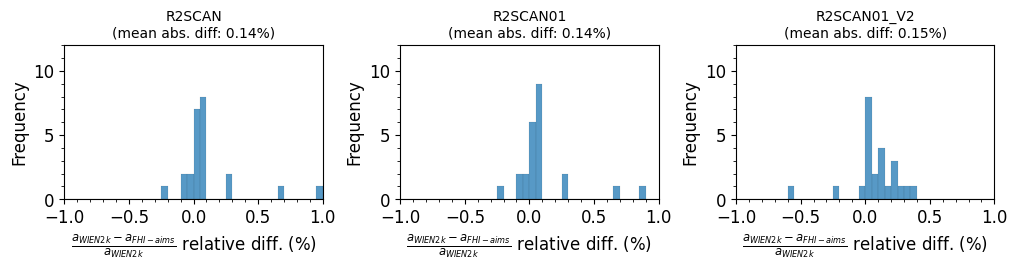

In [64]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 2))
plt.subplots_adjust(hspace=0.45, wspace=0.3)

for i, funct in enumerate(['r2scan', 'r2scan01', 'r2scan01_v2']):
    ax = axes[i]
    
    df_wien2k_fhi_aims[f'{funct}_rel_diff'] = (
        df_wien2k_fhi_aims[f'{funct}_WIEN2k'] - df_wien2k_fhi_aims[f'{funct}_FHI_aims']
    ) / df_wien2k_fhi_aims[f'{funct}_WIEN2k'] * 100

    wien2k_fhi_aims_rel_diff = df_wien2k_fhi_aims[f'{funct}_rel_diff']

    _ = sns.histplot(wien2k_fhi_aims_rel_diff, bins=np.arange(-10, 10, 0.05), ax=ax)
    ax.set_xlabel('$\\frac{{a_{WIEN2k} - a_{FHI-aims}}}{{a_{WIEN2k}}}$ relative diff. (%)')
    ax.yaxis.get_major_locator().set_params(integer=True, nbins=5)
    ax.minorticks_on()
    ax.set_ylabel('Frequency')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 12)
    ax.set_title(f'{funct.upper()}\n(mean abs. diff: {wien2k_fhi_aims_rel_diff.abs().mean():.2f}%)', fontsize=10)
    
    print(funct, wien2k_fhi_aims_rel_diff[wien2k_fhi_aims_rel_diff.abs() > 0.2], '\n')

plt.savefig('wien2k_fhi_aims_r2scan_diff.png', bbox_inches='tight')

In [61]:
df_wien2k_fhi_aims

,pbe,scan,r2scan_WIEN2k,r2scan01_WIEN2k,r2scan01_v2_WIEN2k,r2scan_FHI_aims,r2scan01_FHI_aims,r2scan01_v2_FHI_aims,r2scan_rel_diff,r2scan01_rel_diff,r2scan01_v2_rel_diff
element,,,,,,,,,,,
Ag,4.1478,4.0823,4.1045,4.1068,4.1068,4.102140,4.104362,4.101511,0.057506,0.059355,0.128776
Al,4.0407,4.0119,3.9953,3.9958,3.9958,3.995089,3.995617,3.993356,0.005279,0.004591,0.061155
Au,4.1585,4.0950,4.1253,4.1273,4.1273,4.124025,4.125944,4.125928,0.030915,0.032848,0.033251
Ba,5.0219,5.0783,5.0694,5.0709,5.0709,5.074263,5.075480,5.059885,-0.095935,-0.090311,0.217225
Ca,5.5277,5.5389,5.5667,5.5676,5.5676,5.570639,5.571531,5.555945,-0.070767,-0.070604,0.209328
C,3.5715,3.5532,3.5596,3.5597,3.5597,3.558529,3.558647,3.558479,0.030075,0.029570,0.034315
Cs,6.1611,6.2201,6.2756,6.2741,6.2741,6.214891,6.218108,6.255644,0.967388,0.892436,0.294168
Cu,3.6289,3.5569,3.5753,3.5768,3.5768,3.573191,3.574758,3.571789,0.058993,0.057081,0.140101
Ge,5.7611,5.6671,5.6780,5.6802,5.6802,5.672424,5.674612,5.672650,0.098210,0.098375,0.132923


In [62]:
df_wien2k_fhi_aims.to_excel('wien2k_fhi_aims_lattice_constants.xlsx')